In [1]:
from energyflow.archs.moment import EFN_moment, PFN_moment
from energyflow.archs.moment_layers import Moment
from sklearn.metrics import roc_auc_score
from utils.data_utils import load_data
try:
    from config import base_dir
except:
    raise ValueError("Please specify a base analysis directory, base_dir, in config.py!")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import scipy.special

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2023-09-10 22:41:24.673675: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-10 22:41:24.674933: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 22:41:24.700722: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 22:41:24.701351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 22:41:25.137716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  0
GPUs Available:  []


In [2]:
# Turn off TEST_MODE to run on full dataset
TEST_MODE = False

# Parameters 
train = 10000
val = 50000
test = 50000
Phi, F = 25, 25
R = 0.4


k_orders = [1, 2, 3, 4]
colors = ["red", "orange", "green", "blue"]
dataset = "qg"
run_name = "test"
is_EFN = True
categorical = False # True to use one-hot encoding for labels

num_models_to_train = 1



# Load data
(X_train, X_val, X_test,), (Y_train, Y_val, Y_test,) = load_data(dataset, train, val, test, 
                                                                 EFN_format=is_EFN, 
                                                                 categorical=categorical)
print("Data loaded!")


Data loaded!


In [17]:

def eval_filters(model, latent_dim, patch, n = 100):

    input_t = model.layers[0].input
    output_t = model.layers[6].output
    print(input_t)
    print(output_t)

    func = tf.keras.backend.function(input_t, output_t)


    xmin, ymin, xmax, ymax = -0, -0, R, 0.001
    nx = ny = 100
    xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    XY = np.asarray([X, Y]).reshape((1, 2, nx*ny)).transpose((0, 2, 1))

    Z = func(XY)[0].reshape(nx, ny, latent_dim).transpose((2, 0, 1))
    Z = Z[np.any(Z, axis=(1,2))]

    return X, Y, Z


Run directory:  Data/test/order_1
[<keras.engine.input_layer.InputLayer object at 0x7f48338901c0>, <keras.layers.rnn.time_distributed.TimeDistributed object at 0x7f48338903d0>, <keras.layers.activation.leaky_relu.LeakyReLU object at 0x7f4833890d00>, <keras.layers.rnn.time_distributed.TimeDistributed object at 0x7f483389e070>, <keras.layers.activation.leaky_relu.LeakyReLU object at 0x7f483389e6a0>, <keras.layers.rnn.time_distributed.TimeDistributed object at 0x7f483389ea30>, <keras.layers.activation.leaky_relu.LeakyReLU object at 0x7f48338a90d0>, <keras.engine.input_layer.InputLayer object at 0x7f48338a9160>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x7f48338a9730>, <keras.layers.core.lambda_layer.Lambda object at 0x7f4833a2be20>, <energyflow.archs.moment_layers.Moment object at 0x7f48338a9b80>, <keras.layers.merging.dot.Dot object at 0x7f48338a9be0>, <keras.layers.core.dense.Dense object at 0x7f48338a9c70>, <keras.layers.activation.leaky_relu.LeakyReLU object at 0x7f48338ae3

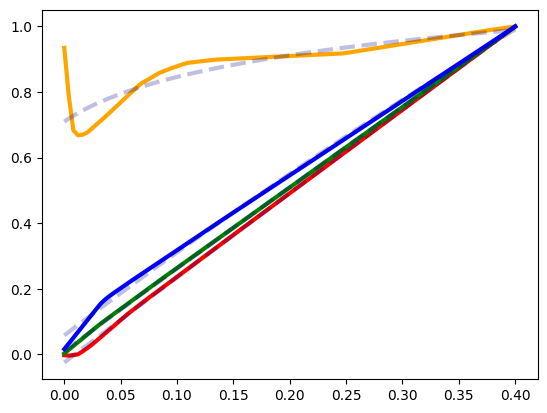

In [21]:


for (i, k_order) in enumerate(k_orders):


    # Directory Handling
    run_dir = os.path.join(base_dir, "Data", run_name)
    run_dir = os.path.join(run_dir, f"order_{k_order}")
    model_dir = os.path.join(run_dir, "Models")
    print("Run directory: ", run_dir)

    configs = np.load(os.path.join(run_dir, "configs.npy"), allow_pickle=True)
    config = configs[0]

    
    for j in range(num_models_to_train):

        # Load Model
        L = 1
        model_name = f"O{k_order}_L{L}_2Phi{Phi}_3F{F}_{j}.keras"
        model_filepath = os.path.join(model_dir , model_name)

        # load model
        model = tf.keras.models.load_model(model_filepath, custom_objects={'Moment': Moment})
        print(model.layers)




        # model = EFN_moment(**config, filepath = model_filepath, metrics =  ['acc', tf.keras.metrics.AUC()], summary=False)
        # model.load_weights(filepath = model_filepath, by_name=True)

        # Evaluate AUC
        Y_pred = model.predict(X_test)
        auc = roc_auc_score(Y_test, Y_pred)
        print("AUC: ", auc)

        # Evaluate Filter
        X, Y, Z = eval_filters(model, latent_dim=L, patch = [0, 0, R, 0.000],n = 100)
        z = Z[0]

        # Perform log fit
        x = X[:,0]
        y = z[:,0] / np.max(np.abs(z[:,0]))
        plt.plot(X[:,0], y, lw = 3, label = "Latent Space", color = colors[i])

        a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:], p0=[1,1,0.010], maxfev=5000)[0]
        y_log = a + b*np.log(x + c)
        print(a, b, c)
        # b, a = np.polyfit(np.log(x[25:]), y[15:], 1)
        plt.plot(x[0:], y_log[0:], color = "darkblue", alpha = 0.25, lw = 3, ls = "--", label = "Fit: $c_1 + c_2$log$(c_3 + y)$")
        # print(Z)

        # plt.text(0.375, 0.775-0.075*0, "$c_1 = %.3f$" % a, horizontalalignment='left', verticalalignment='center', transform=axes.transAxes)
        # plt.text(0.375, 0.775-0.075*1, "$c_2 = %.3f$" % b, horizontalTruealignment='left', verticalalignment='center', transform=axes.transAxes)
        # plt.text(0.375, 0.775-0.075*2, "$c_3 = %.3f$" % c, horizontalalignment='left', verticalalignment='center', transform=axes.transAxes)


